In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
import os
import glob
import functools

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

In [0]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import layers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.python.keras import backend as K  

In [0]:
!pip install SimpleITK

    100% |████████████████████████████████| 42.5MB 1.2MB/s 


In [0]:
import h5py
import SimpleITK as sitk

Find training data filenames and label filenames 

In [0]:
def getTrainNLabelNames(data_folder, m, ext='*.nii.gz'):
  x_train_filenames = []
  y_train_filenames = []
  for subject_dir in sorted(glob.glob(os.path.join(data_folder,m+'_train',ext))):
      x_train_filenames.append(os.path.realpath(subject_dir))
  for subject_dir in sorted(glob.glob(os.path.join(data_folder ,m+'_train_masks',ext))):
      y_train_filenames.append(os.path.realpath(subject_dir))
  return x_train_filenames, y_train_filenames


Preprocess image - fix intensity

In [0]:
def HistogramEqualization(sitkIm):
    if type(sitkIm) is np.ndarray:
        pyIm = sitkIm
    else:
        pyIm = sitk.GetArrayFromImage(sitkIm)
    pyImNew = np.empty(pyIm.shape)
    for index,image in enumerate(pyIm):
        num = int(max(image.flatten())-min(image.flatten()))+1
        im_hist, bins = np.histogram(image.flatten(), num)
        
        cdf = im_hist.cumsum()
        cdf = max(image.flatten()) * cdf /cdf[-1]
        
        image_equalized = np.interp(image.flatten(),bins[:-1],cdf)
        pyImNew[index] = np.reshape(image_equalized,image.shape)
    
    return pyImNew
 
#  def normalization(image_names,axis):
#     sum_pixel = 0.
#     pixel_num = 0
#     for im_fn in image_names:
#       imgVol = sitk.GetArrayFromImage(sitk.RescaleIntensity(sitk.ReadImage(img_path),200,2000))  # numpy array
#       imgVol = HistogramEqualization(imgVol)
#       sum_pixel +=np.sum(imgVol)
#       pixel_num += imgVol.shape[0]* imgVol.shape[1]*imgVol.shape[2]
      
#     avg = sum_pixel/pixel_num
#     print("avg pixel intensity is %d" % int(avg))
    
#     sum_pixel = 0
#     for im_fn in image_names:
#       imgVol = sitk.GetArrayFromImage(sitk.RescaleIntensity(sitk.ReadImage(img_path),200,2000))  # numpy array
#       imgVol = HistogramEqualization(imgVol) - avg
#       sum_pixel +=np.sum(imgVol**2)

#     std = np.sqrt(sum_pixel/pixel_num)
    
    

IndentationError: ignored

Convert 3D data to 2D data

In [0]:
def swapLabels(labels):
    labels[labels==421]=420
    labels[labels==420]=0
    labels[labels==550]=0
    labels[labels==600]=0
    labels[labels==820]=0
    labels[labels==850]=0
    labels[labels==500]=0
    unique_label = np.unique(labels)

    new_label = range(len(unique_label))
    for i in range(len(unique_label)):
        label = unique_label[i]
        print(label)
        newl = new_label[i]
        print(newl)
        labels[labels==label] = newl
       
    print(unique_label)

    return labels

In [0]:
def data_preprocess(modality,data_folder,view, data_folder_out):
  for m in modality:
    imgVol_fn, mask_fn = getTrainNLabelNames(data_folder, m)
    print("number of training data %d" % len(imgVol_fn))
    assert len(imgVol_fn) == len(mask_fn)

    train_img_path = []
    train_mask_path = []
    for i in range(0,len(imgVol_fn)):
      img_path = imgVol_fn[i]
      mask_path = mask_fn[i]
      imgVol = sitk.GetArrayFromImage(sitk.ReadImage(img_path))  # numpy array
      #imgVol = HistogramEqualization(imgVol)
      maskVol = sitk.GetArrayFromImage(sitk.ReadImage(mask_path))  # numpy array
      maskVol = swapLabels(maskVol)
      print("number of image slices in this view %d" % imgVol.shape[view])
      for sid in range(imgVol.shape[view]):
        out_im_path = os.path.join(data_folder_out, m+'_train', m+'_train'+str(i)+'_'+str(sid))
        out_msk_path = os.path.join(data_folder_out, m+'_train_masks',  m+'_train_mask'+str(i)+'_'+str(sid))
        slice_im = np.moveaxis(imgVol,view,0)[sid,:,:]
        slice_msk = np.moveaxis(maskVol,view,0)[sid,:,:]
        sitk.WriteImage(sitk.Cast(sitk.RescaleIntensity(sitk.GetImageFromArray(slice_im.astype(np.uint16))), sitk.sitkUInt8),out_im_path+'.png')
        sitk.WriteImage(sitk.Cast(sitk.RescaleIntensity(sitk.GetImageFromArray(slice_msk.astype(np.uint16))), sitk.sitkUInt8), out_msk_path+'.png')
        scaled_slice = sitk.Cast(sitk.RescaleIntensity(sitk.GetImageFromArray(slice_im.astype(np.uint16))), sitk.sitkUInt8)
        #np.save(out_im_path+'.npy',sitk.GetArrayFromImage(scaled_slice))
        #np.save(out_msk_path+'.npy', slice_msk)
        train_img_path.append(out_im_path)
        train_mask_path.append(out_msk_path)
  return train_img_path, train_mask_path

In [0]:
modality = ["mr"]
data_folder = '/content/gdrive/My Drive/ImageData/MMWHS'
view = 0
data_folder_out = '/content/gdrive/My Drive/ImageData/MMWHS/2D_2'
#print("Making dir...")
#os.mkdir(data_folder_out)
#os.mkdir(os.path.join(data_folder_out, m+'_train'))
#os.mkdir(os.path.join(data_folder_out, m+'_train_masks'))
overwrite = False
if overwrite:
  x_train_filenames, y_train_filenames = data_preprocess(modality,data_folder,view, data_folder_out)
else:
  x_train_filenames, y_train_filenames = getTrainNLabelNames(data_folder_out, modality[0], ext='*.png')


In [0]:

# x_train_filenames = [i+'.png' for i in x_train_filenames]
# y_train_filenames = [i+'.png' for i in y_train_filenames]
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

x_train_filenames[:10]
#y_train_filenames[:10]


Number of training examples: 2966
Number of validation examples: 742


['/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train0_49.png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train10_4.png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train6_39.png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train2_3.png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train0_51.png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train2_151 (1).png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train14_180.png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train16_80 (1).png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train1_5.png',
 '/content/gdrive/My Drive/ImageData/MMWHS/2D_2/mr_train/mr_train11_0 (1).png']

# Visualize
Let's take a look at some of the examples of different images in our dataset. 

[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]


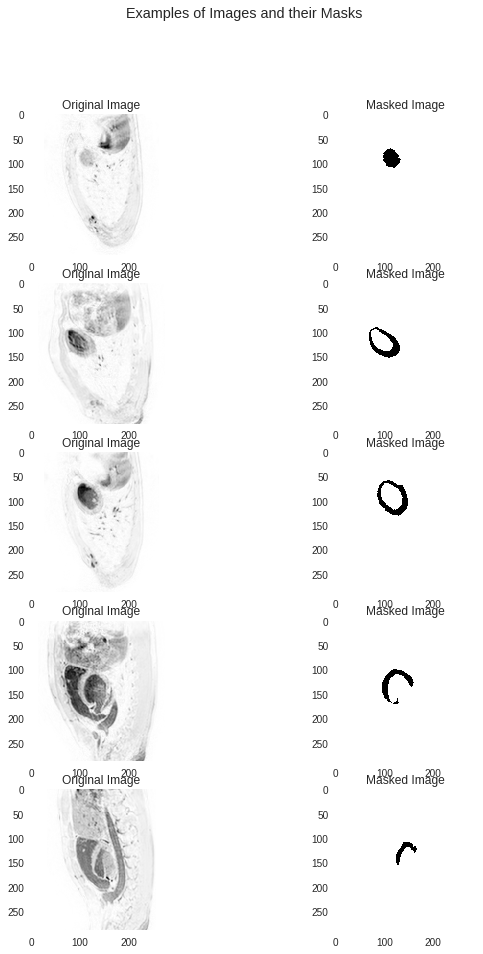

In [0]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
  img_num = r_choices[i // 2]
  x_pathname = x_train_filenames[img_num]
  y_pathname = y_train_filenames[img_num]
  
  plt.subplot(display_num, 2, i + 1)
  plt.imshow(mpimg.imread(x_pathname))
  
  plt.title("Original Image")
  
  example_labels = mpimg.imread(y_pathname)
  label_vals = np.unique(example_labels)
  print(label_vals)
  
  plt.subplot(display_num, 2, i + 2)
  plt.imshow(example_labels)
  plt.title("Masked Image")  
  
plt.suptitle("Examples of Images and their Masks")
plt.show()

# Set up 

In [0]:
img_shape = (256, 256, 1)
batch_size = 5
epochs = 300

# Build our input pipeline with `tf.data`



## Processing each pathname

In [0]:
def _process_pathnames(fname, label_path):
  # We map this function onto each pathname pair  
  img_str = tf.read_file(fname)
  img = tf.image.decode_png(img_str, channels=1)

  label_img_str = tf.read_file(label_path)
  label_img = tf.image.decode_png(label_img_str, channels=1)
  #y = tf.one_hot(tf.cast(label_img, tf.uint8), 8, on_value=1.0, off_value=0.0,
  #         axis=-1)
  #print(y.shape)
  #label_img = tf.expand_dims(label_img, axis=-1)
  return img, label_img

## Shifting the image

In [0]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
  """This fn will perform the horizontal or vertical shift"""
  if width_shift_range or height_shift_range:
      if width_shift_range:
        width_shift_range = tf.random_uniform([], 
                                              -width_shift_range * img_shape[1],
                                              width_shift_range * img_shape[1])
      if height_shift_range:
        height_shift_range = tf.random_uniform([],
                                               -height_shift_range * img_shape[0],
                                               height_shift_range * img_shape[0])
      # Translate both 
      output_img = tfcontrib.image.translate(output_img,
                                             [width_shift_range, height_shift_range])
      label_img = tfcontrib.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
  return output_img, label_img

## Flipping the image randomly 

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

## Assembling our transformations into our augment function


In [0]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically 
  if resize is not None:
    # Resize both images
    label_img = tf.image.resize_images(label_img, resize)
    img = tf.image.resize_images(img, resize)
  
  
  img, label_img = flip_img(horizontal_flip, img, label_img)
  img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
  return img, label_img

In [0]:
def _normalize(img, label_img):
    label_img = tf.round(tf.divide(label_img,255))
    return img, label_img

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  dataset = dataset.map(_normalize, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

## Set up train and validation datasets
Note that we apply image augmentation to our training dataset but not our validation dataset. 

In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [0]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

## Let's see if our image augmentor data pipeline is producing expected results

(256, 256, 1)
(10, 256, 256, 1)
[0. 1.]


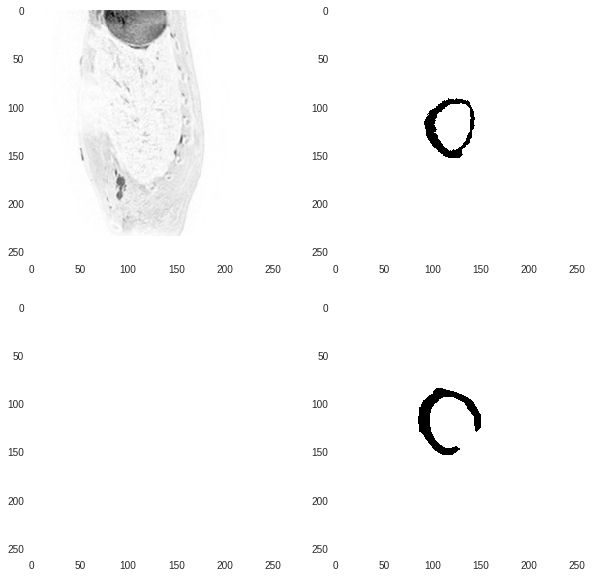

In [0]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=10,
                               shuffle=True)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[1]
  print(img.shape)
  print(label.shape)
  print(np.unique(label))

  plt.subplot(2, 2, 1)
  plt.imshow(img[:,:,0])

  plt.subplot(2, 2, 2)
  plt.imshow(label[0, :, :, 0])
  
  plt.subplot(2, 2, 3)
  plt.imshow(label[2, :, :, 0])
  
  plt.subplot(2, 2, 4)
  plt.imshow(label[4, :, :, 0])
  plt.show()

# Build the model

In [0]:
def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

In [0]:
inputs = layers.Input(shape=img_shape)
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [0]:
model = models.Model(inputs=[inputs], outputs=[outputs])

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

In [0]:
save_model_path = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [0]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/300
463/464 [============================>.] - ETA: 0s - loss: 1.3993 - dice_loss: 0.4337
Epoch 00001: val_dice_loss did not improve from 0.40340
464/464 [==============================] - 203s 438ms/step - loss: 1.3998 - dice_loss: 0.4339 - val_loss: 1.9963 - val_dice_loss: 0.5877
Epoch 2/300
463/464 [============================>.] - ETA: 0s - loss: 1.5220 - dice_loss: 0.4655
Epoch 00002: val_dice_loss improved from 0.40340 to 0.39436, saving model to /content/gdrive/My Drive/DeepLearning/2DUNet/Logs/weights.hdf5
464/464 [==============================] - 196s 422ms/step - loss: 1.5251 - dice_loss: 0.4667 - val_loss: 1.2663 - val_dice_loss: 0.3944
Epoch 3/300
463/464 [============================>.] - ETA: 0s - loss: 1.2309 - dice_loss: 0.3794
Epoch 00003: val_dice_loss improved from 0.39436 to 0.29297, saving model to /content/gdrive/My Drive/DeepLearning/2DUNet/Logs/weights.hdf5
464/464 [==============================] - 169s 365ms/step - loss: 1.2295 - dice_loss: 0.3789 - 

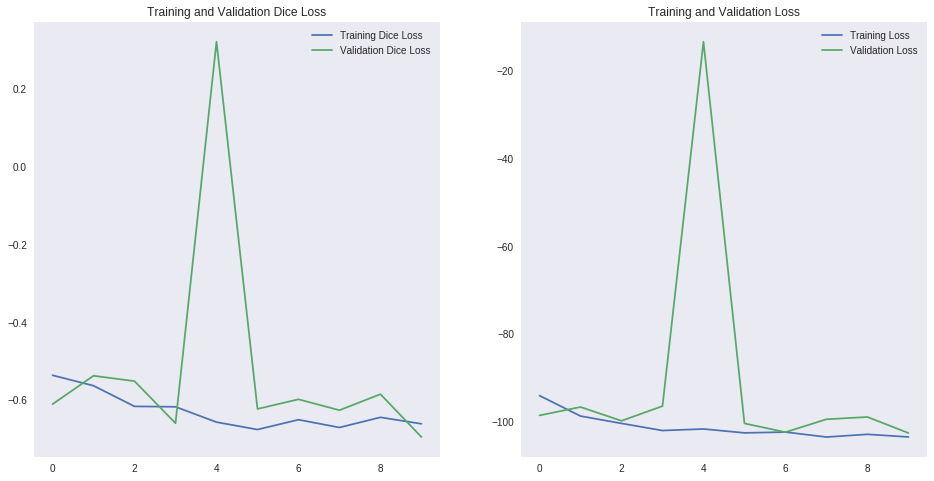

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
# Alternatively, load the weights directly: model.load_weights(save_model_path)
model = models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

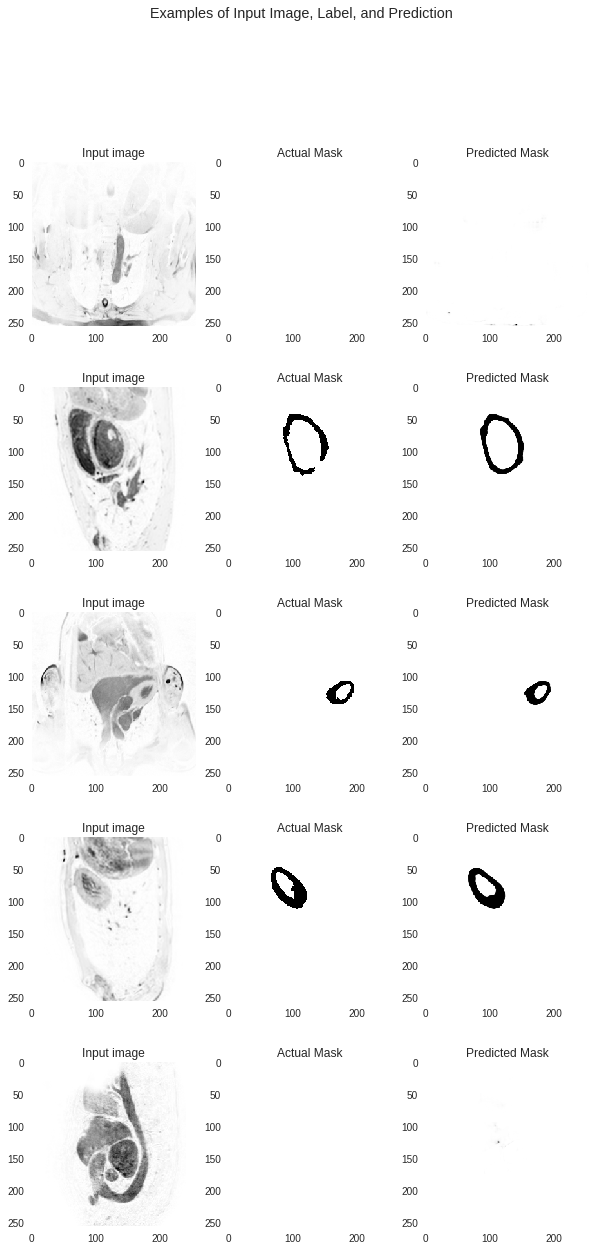

In [0]:
# Let's visualize some of the outputs 
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 20))
for i in range(5):
  batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
  img = batch_of_imgs[0]
  predicted_label = model.predict(batch_of_imgs)[0]

  plt.subplot(5, 3, 3 * i + 1)
  plt.imshow(img[:,:,0])
  plt.title("Input image")
  
  plt.subplot(5, 3, 3 * i + 2)
  plt.imshow(label[0, :, :, 0])
  plt.title("Actual Mask")
  plt.subplot(5, 3, 3 * i + 3)
  plt.imshow(predicted_label[:, :, 0])
  plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()